## 2b. Trial by trial decoding analysis - copy

### (Map ExtendedRipple's decode, insert into the Database.)
[This notebook uses TrialChoice() and ExtendedRippleTimes() to populate the TrialChoiceReplay() table.]
##### All the tables mentioned above are under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.
##### Can jump to the section that has plotting on top of parsing.

Jun 23, 2024
Shijie Gu

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

import spyglass.spikesorting as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
#from spyglass.decoding.clusterless import (UnitMarks,
#                                           UnitMarkParameters,UnitMarksIndicatorSelection,
#                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition

from spyglass.shijiegu.load import load_epoch_data
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   DecodeResultsLinear,get_linearization_map,
                                   find_ripple_times,mua_thresholder,sort_replays,
                                   classify_ripples,classify_ripple_content,
                                   load_everything,MUA,
                                   TetrodeNumber
                                  )
from spyglass.shijiegu.Analysis_SGU import EpochPos,ExtendedRippleTimes,ExtendedRippleTimesWithDecode
from spyglass.shijiegu.ripple_add_replay import (replay_parser_master,plot_ripples_replays)

[2024-11-16 21:31:28,309][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
16-Nov-24 21:31:28 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-11-16 21:31:28,345][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
16-Nov-24 21:31:28 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [32]:
# the only cell to be edited
nwb_file_name = 'haydn20230605.nwb'

In [33]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

### 1. for all sessions without plotting

#### causal

In [ ]:
from spyglass.shijiegu.Analysis_SGU import ExtendedTrialChoiceReplay

all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
print(nwb_copy_file_name, all_epochs)

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'causal_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'
causal = True

for epoch_num in all_epochs:
    (epoch_name,log_df,ripple_times,decode,
     head_speed,head_orientation,linear_position_df,
     lfp_df,theta_df,ripple_df,neural_df,mua_df) = replay_parser_master(nwb_file_name,epoch_num,
                                                                        extended = True,
                                                                        classifier_param_name = classifier_param_name,
                                                                        encoding_set = encoding_set,
                                                                        decode_threshold_method = decode_threshold_method,
                                                                        causal = causal)

#### acausal, extended

In [29]:
from spyglass.shijiegu.Analysis_SGU import ExtendedTrialChoiceReplay

all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
print(nwb_copy_file_name, all_epochs)

encoding_set = '2Dheadspeed_above_4' #encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'
causal = False

for epoch_num in [2]:#all_epochs:
    (epoch_name,log_df,ripple_times,decode,
     head_speed,head_orientation,linear_position_df,
     lfp_df,theta_df,ripple_df,neural_df,mua_df) = replay_parser_master(nwb_file_name,epoch_num,
                                                                        extended = True,
                                                                        classifier_param_name = classifier_param_name,
                                                                        encoding_set = encoding_set,
                                                                        decode_threshold_method = decode_threshold_method,
                                                                        causal = causal)

[15:24:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
26-Oct-24 15:24:09 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


lewis20240109_.nwb [2, 4, 6, 8]
epoch name 02_Rev2Session1
epoch name 02_Rev2Session1
epoch_pos_name pos 1 valid times


[2024-10-26 15:24:09,525][WARNING]: Skipped checksum for file with hash: 936f2207-25ca-c003-d157-dd5a150390d0, and path: /stelmo/nwb/analysis/lewis20240109/lewis20240109_LVY1KHPBGX.nwb
26-Oct-24 15:24:09 Skipped checksum for file with hash: 936f2207-25ca-c003-d157-dd5a150390d0, and path: /stelmo/nwb/analysis/lewis20240109/lewis20240109_LVY1KHPBGX.nwb


Done parsing. Insert into Spyglass


#### acausal, not extended

In [40]:
from spyglass.shijiegu.Analysis_SGU import ExtendedTrialChoiceReplay

all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
print(nwb_copy_file_name, all_epochs)

encoding_set = '2Dheadspeed_above_4' #encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'
causal = False

for epoch_num in all_epochs:
    (epoch_name,log_df,ripple_times,decode,
     head_speed,head_orientation,linear_position_df,
     lfp_df,theta_df,ripple_df,neural_df,mua_df) = replay_parser_master(nwb_file_name,epoch_num,
                                                                        extended = False,
                                                                        classifier_param_name = classifier_param_name,
                                                                        encoding_set = encoding_set,
                                                                        decode_threshold_method = decode_threshold_method,
                                                                        causal = causal,replace = True)

[14:26:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
22-Aug-24 14:26:56 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


eliot20221019_.nwb [2, 4, 6, 8, 10]
epoch name 02_Seq2Session1
epoch name 02_Seq2Session1
epoch_pos_name pos 1 valid times


[2024-08-22 14:26:59,290][WARNING]: Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
22-Aug-24 14:26:59 Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
[14:29:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
22-Aug-24 14:29:21 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


Done parsing. Insert into Spyglass
epoch name 04_Seq2Session2
epoch name 04_Seq2Session2
epoch_pos_name pos 3 valid times


[2024-08-22 14:29:23,373][WARNING]: Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
22-Aug-24 14:29:23 Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
[14:31:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
22-Aug-24 14:31:11 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


Done parsing. Insert into Spyglass
epoch name 06_Seq2Session3
epoch name 06_Seq2Session3
epoch_pos_name pos 5 valid times


[2024-08-22 14:31:13,286][WARNING]: Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
22-Aug-24 14:31:13 Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
[14:33:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
22-Aug-24 14:33:01 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


Done parsing. Insert into Spyglass
epoch name 08_Seq2Session4
epoch name 08_Seq2Session4
epoch_pos_name pos 7 valid times


[2024-08-22 14:33:02,748][WARNING]: Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
22-Aug-24 14:33:02 Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
[14:34:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
22-Aug-24 14:34:59 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


Done parsing. Insert into Spyglass
epoch name 10_Seq2Session5
epoch name 10_Seq2Session5
epoch_pos_name pos 9 valid times


[2024-08-22 14:35:01,055][WARNING]: Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb
22-Aug-24 14:35:01 Skipped checksum for file with hash: e4008074-3b74-dc2d-e6cd-bfc335cbc385, and path: /stelmo/nwb/analysis/eliot20221019/eliot20221019_Q6VIQE364T.nwb


Done parsing. Insert into Spyglass


In [11]:
from spyglass.shijiegu.Analysis_SGU import RippleTimesWithDecode
pd.DataFrame((RippleTimesWithDecode() & {'nwb_file_name':'eliot20221022_.nwb',
                           'interval_list_name':'08_Seq2Session4'}).fetch1('ripple_times'))

start_time      end_time animal_location  trial_number  \
1    1.666477e+09  1.666477e+09           well3             1   
2    1.666477e+09  1.666477e+09           well3             1   
3    1.666477e+09  1.666477e+09           well3             1   
4    1.666477e+09  1.666477e+09            home             2   
5    1.666477e+09  1.666477e+09            home             2   
..            ...           ...             ...           ...   
174  1.666479e+09  1.666479e+09           well1            78   
175  1.666479e+09  1.666479e+09            home            79   
176  1.666479e+09  1.666479e+09            home            80   
177  1.666479e+09  1.666479e+09            home            80   
178  1.666479e+09  1.666479e+09            home            81   

                                            cont_intvl  \
1           [[1666477173.4612288, 1666477173.5412288]]   
2           [[1666477175.1492286, 1666477175.2352283]]   
3           [[1666477183.4352274, 1666477183.5512276]]   
4             [[1666477194.585226, 1666477194.813226]]   
5            [[1666477196.1572258, 1666477196.449226]]   
..                                                 ...   
174         [[1666478858.8810194, 1666478858.9290192]]   
175         [[1666478871.0470178, 1666478871.1610177]]   
176           [[1666478885.889016, 1666478885.943016]]   
177          [[1666478886.985016, 1666478887.1370158]]   
178  [[1666478910.5990129, 1666478910.651013], [166...   

                                    frag_intvl cont_intvl_replay  duration  \
1                                           []             [[0]]  0.114000   
2                                           []             [[0]]  0.088000   
3                                           []             [[3]]  0.119000   
4                                           []             [[2]]  0.238000   
5     [[1666477196.451226, 1666477196.491226]]             [[1]]  0.358001   
..                                         ...               ...       ...   
174                                         []             [[4]]  0.049000   
175                                         []             [[0]]  0.116000   
176   [[1666478885.945016, 1666478886.021016]]             [[1]]  0.141000   
177                                         []             [[0]]  0.155000   
178  [[1666478910.6530128, 1666478910.717013]]         [[], [0]]  0.176000   

     mean_zscore  median_zscore  max_zscore  min_zscore  speed_at_start  \
1       1.695003       1.268383    5.508651    0.046788        0.327307   
2       1.447719       1.425344    3.710729   -0.893340        0.811143   
3       1.255485       1.192060    3.295221   -1.052925        0.944317   
4       1.531007       1.223962    4.866561    0.028493        0.118580   
5       1.945267       1.670207    6.004021   -0.443112        0.118580   
..           ...            ...         ...         ...             ...   
174     1.707761       2.276918    3.809341   -0.704509        0.268794   
175     1.681746       1.729267    4.231959   -0.475811        3.932809   
176     1.563317       1.308845    4.361792    0.009921        1.953375   
177     1.233628       1.172704    2.960304   -0.622779        1.951065   
178     1.856089       1.304406    4.864219    0.005744        1.573104   

     speed_at_end  max_speed  min_speed  median_speed  mean_speed  
1        0.260079   0.327307   0.213945      0.234420    0.245426  
2        0.967552   0.967552   0.811143      0.917541    0.909881  
3        2.546033   2.546033   0.414947      1.178978    1.354465  
4        0.118582   0.118582   0.118580      0.118580    0.118580  
5        0.075129   0.118580   0.075129      0.118448    0.113918  
..            ...        ...        ...           ...         ...  
174      0.605716   0.605716   0.225571      0.312721    0.358011  
175      3.050164   3.932809   1.084972      2.393645    2.289071  
176      1.953392   1.953392   1.953370      1.953374    1.953377  
177      1.

### 2. for all sessions with plotting

#### acausal extended

In [34]:
all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))

In [39]:
all_epochs

[2, 4, 6, 8, 10, 12]

In [36]:
nwb_copy_file_name

'haydn20230605_.nwb'

In [ ]:
%matplotlib agg
from spyglass.shijiegu.Analysis_SGU import ExtendedTrialChoiceReplay

all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'
causal = False
extended = True

for epoch_num in [12]:#all_epochs:

    (epoch_name,log_df,ripple_times,decode,
     head_speed,head_orientation,linear_position_df,
     lfp_df,theta_df,ripple_df,neural_df,mua_df) = replay_parser_master(nwb_file_name,epoch_num,
                                                                        extended = extended, #True
                                                                        classifier_param_name = classifier_param_name,
                                                                        encoding_set = encoding_set,
                                                                        decode_threshold_method = decode_threshold_method,
                                                                        causal = causal)


    """
    REAL WORK ENDS HERE, THE REST IS JUST PLOTTING
    """

    ## find tetrodes with signal
    groups_with_cell=(SpikeSortingRecordingSelection & {
        'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
    groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])
    channel_IDs = list(neural_df.keys())
    
    spikeColInd = {}
    for g in groups_with_cell:
        spikeColInd_ = np.argwhere(np.isin(channel_IDs,(Electrode() &  {'nwb_file_name' : nwb_copy_file_name,
                                                     'electrode_group_name':str(g)}).fetch('electrode_id'))).ravel()
        spikeColInd[g] = spikeColInd_

    # Pre-make result directory:
    decoding_path=(DecodeResultsLinear() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    if causal:
        causal_str = 'causal'
    else:
        causal_str = 'acausal'

    if extended:
        exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,'extended_SWR'+'_'+encoding_set+'_'+causal_str+'_'+classifier_param_name+'_'+decode_threshold_method,epoch_name)
    else:
        exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,'SWR'+'_'+encoding_set+'_'+causal_str+'_'+classifier_param_name+'_'+decode_threshold_method,epoch_name)
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)
    savefolder = exampledir
    print(savefolder)

    if decode_threshold_method == 'MUA_M05SD':
        mua_thresh = (MUA & {'nwb_file_name' : nwb_copy_file_name,
                             'interval_list_name':epoch_name}).fetch1('mean') - 0.5 * (MUA & {'nwb_file_name' : nwb_copy_file_name,
                             'interval_list_name':epoch_name}).fetch1('sd')
    elif decode_threshold_method == 'MUA_0SD':
        mua_thresh = (MUA & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':epoch_name}).fetch1('mean')


    for t in log_df.index[:-2]:
        # Home
        ripples = log_df.loc[t].ripple_H
        ripple_table_inds = log_df.loc[t].ripple_ID_H

        if not np.isnan(log_df.loc[t].timestamp_H):
            plottimes = [log_df.loc[t].timestamp_H,log_df.loc[t].timestamp_H + 6]
            savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name + '_whole_trial'
            plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                         linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                         neural_df,mua_df,head_speed,head_orientation,
                         savename,savefolder,wholeTrial = 1,plottimes=plottimes,mua_thresh = mua_thresh, causal = causal)
            
        savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name
        plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                     linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                     neural_df,mua_df,head_speed,head_orientation,
                     savename,savefolder,wholeTrial = 0,mua_thresh = mua_thresh, causal = causal)
    
        
            
        # Outer Well
            
        ripples = log_df.loc[t].ripple_O
        ripple_table_inds = log_df.loc[t].ripple_ID_O

        plottimes = [log_df.loc[t].timestamp_O,log_df.loc[t].timestamp_O + 6]
        savename = 'trial' + str(t) + '_well_' + nwb_copy_file_name[:-5] + '_' + epoch_name + '_whole_trial'
        plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                     linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                     neural_df,mua_df,head_speed,head_orientation,
                     savename,savefolder,wholeTrial = 1,plottimes=plottimes,mua_thresh = mua_thresh, causal = causal)
        
        savename = 'trial' + str(t) + '_well_' + nwb_copy_file_name[:-5] + '_' + epoch_name
        plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                     linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                     neural_df,mua_df,head_speed,head_orientation,
                     savename,savefolder,wholeTrial = 0,mua_thresh = mua_thresh, causal = causal)
    
        

[22:04:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
21-Nov-24 22:04:03 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


epoch name 12_Rev3Session6
epoch name 12_Rev3Session6
epoch_pos_name pos 11 valid times


[2024-11-21 22:04:04,447][WARNING]: Skipped checksum for file with hash: 8d6d2763-66d7-1445-d1d4-54d41c5b4cc8, and path: /stelmo/nwb/analysis/haydn20230605/haydn20230605_FRL5OXHDPT.nwb
21-Nov-24 22:04:04 Skipped checksum for file with hash: 8d6d2763-66d7-1445-d1d4-54d41c5b4cc8, and path: /stelmo/nwb/analysis/haydn20230605/haydn20230605_FRL5OXHDPT.nwb


Using LFP from these eletrodes: 
[ 1  2 11 12 15 16 20 22 24 30]


Done parsing. Insert into Spyglass
/cumulus/shijie/recording_pilot/haydn/decoding/haydn20230605.nwb/extended_SWR_2Dheadspeed_above_4_acausal_default_decoding_gpu_4armMaze_MUA_0SD/12_Rev3Session6


OSError: [Errno 28] No space left on device: '/cumulus/shijie/recording_pilot/haydn/decoding/haydn20230605.nwb/extended_SWR_2Dheadspeed_above_4_acausal_default_decoding_gpu_4armMaze_MUA_0SD/12_Rev3Session6/trial18_well_haydn20230605_12_Rev3Session6_whole_trial.pdf'

In [40]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/matplotlib/cbook.py(483)to_filehandle()
    481             fh = bz2.BZ2File(fname, flag)
    482         else:
--> 483             fh = open(fname, flag, encoding=encoding)
    484         opened = True
    485     elif hasattr(fname, 'seek'):



ipdb>  exit


In [ ]:
(ExtendedRippleTimesWithDecode() & {'nwb_file_name': nwb_copy_file_name})

In [30]:
print('all done')

all done


In [10]:
epoch_num = 8

### Begin testing

In [64]:
nwb_file_name = 'eliot20221021.nwb'
epoch_num = 8

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
# 1. Load state script
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
epoch_name=(TrialChoice & key).fetch1('epoch_name')
print('epoch name',epoch_name)

epoch name 08_Seq2Session4


In [65]:
ripple_times = pd.DataFrame((ExtendedRippleTimes() & {'nwb_file_name': nwb_copy_file_name,
                                              'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [67]:
ripple_times.loc[74]

start_time                                           1666398565.631176
end_time                                             1666398566.404176
animal_location                                                   home
trial_number                                                        40
cont_intvl           [[1666398565.631427, 1666398565.7414272], [166...
frag_intvl           [[1666398565.8634272, 1666398565.897427], [166...
cont_intvl_replay                          [[2], [1], [], [], [], [0]]
duration                                                         0.773
mean_zscore                                                   3.373377
median_zscore                                                  0.95146
max_zscore                                                   29.612075
min_zscore                                                   -0.856005
max_speed                                                     0.335395
min_speed                                                      0.33539
median

In [25]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
# 1. Load state script
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
epoch_name=(TrialChoice & key).fetch1('epoch_name')
print('epoch name',epoch_name)

# 2. load data
linear_map,node_location=get_linearization_map()
(epoch_name,log_df,decode,head_speed,head_orientation,linear_position_df,
        lfp_df,theta_df,ripple_df,neural_df,_) = load_epoch_data(nwb_copy_file_name,epoch_num)
# load MUA
mua_path=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':epoch_name}).fetch1('mua_trace')
mua_xr = xr.open_dataset(mua_path)
mua_threshold=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':epoch_name}).fetch1('mean')



[13:46:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
28-Jun-24 13:46:01 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


epoch name 02_Seq2Session1
epoch name 02_Seq2Session1
epoch_pos_name pos 1 valid times


[2024-06-28 13:46:02,034][WARNING]: Skipped checksum for file with hash: 65756212-f56e-fc3c-339a-369742efcaf5, and path: /stelmo/nwb/analysis/eliot20221021/eliot20221021_O0JEUX5SSA.nwb
28-Jun-24 13:46:02 Skipped checksum for file with hash: 65756212-f56e-fc3c-339a-369742efcaf5, and path: /stelmo/nwb/analysis/eliot20221021/eliot20221021_O0JEUX5SSA.nwb


In [31]:
r_ind = 10

In [32]:
(t0,t1) = (ripple_times.loc[r_ind,'start_time'],ripple_times.loc[r_ind,'end_time'])
linear_position_subset = linear_position_df.isel(
    time=np.logical_and(linear_position_df.time >= t0,linear_position_df.time <= t1))
        

In [46]:
ripple_times.loc[1,'start_time']

1666383001.400295

In [37]:
int(linear_position_df.time[0])

1666382928

In [32]:
from spyglass.shijiegu.ripple_detection import (loadRippleLFP_OneChannelPerElectrode,
removeDataBeforeTrial1,removeArtifactTime)
from spyglass.shijiegu.load import load_position
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time

epochID = epoch_num
key = (EpochPos & {'nwb_file_name':nwb_copy_file_name,'epoch':epochID}).fetch1()
epoch_name = key['epoch_name']
position_interval = key['position_interval']

position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                            'interval_list_name': position_interval}).fetch1('valid_times')

# Ripple Band LFP
filtered_lfps, filtered_lfps_t, CA1TetrodeInd, CCTetrodeInd = loadRippleLFP_OneChannelPerElectrode(
        nwb_copy_file_name,epoch_name,position_valid_times)


# Remove Data before 1st trial and after last trial
StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,'epoch':int(epoch_name[:2])}).fetch1('choice_reward')
    )
trial_1_t = StateScript.loc[1].timestamp_O
trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O

t_ind = np.logical_and(filtered_lfps_t >= trial_1_t, filtered_lfps_t <= trial_last_t)
filtered_lfps_t = filtered_lfps_t[t_ind]
filtered_lfps = filtered_lfps[t_ind,:]

    # load Position
position_info = load_position(nwb_copy_file_name,position_interval)
position_info_upsample = interpolate_to_new_time(position_info, filtered_lfps_t)
position_info_upsample = removeDataBeforeTrial1(position_info_upsample,trial_1_t,trial_last_t)
position_info_upsample = removeArtifactTime(position_info_upsample, filtered_lfps)

Using LFP from these eletrodes: 
[ 0  2  4  5 13 14 16 17 20 23 26 27 28 29 30 31]




In [46]:
lfp_band_sampling_rate=(LFPBand & {'nwb_file_name':nwb_copy_file_name,
                                    'target_interval_list_name': epoch_name,
                                    'filter_name': 'Ripple 150-250 Hz'}).fetch1('lfp_band_sampling_rate')

ripple_times = pd.DataFrame((RippleTimes() & {'nwb_file_name': nwb_copy_file_name,
                                              'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [35]:
from ripple_detection.core import merge_overlapping_ranges

In [47]:
start_end = np.vstack((np.array(ripple_times.start_time)-0.1,
                                np.array(ripple_times.end_time)+0.1))
start_end_list = [[start_end[0,ci],start_end[1,ci]] for ci in range(start_end.shape[1])]
extended_start_end = np.array(list(merge_overlapping_ranges(start_end_list)))

In [42]:
is_low_speed = pd.Series(np.array(position_info_upsample.head_speed) <= 
                         4, index=filtered_lfps_t)

In [43]:
from ripple_detection.core import segment_boolean_series
extended_start_end_lowSpeed = interval_list_intersect(extended_start_end,
                                             np.array(segment_boolean_series(is_low_speed)))

In [44]:
len(extended_start_end_lowSpeed)

163

In [48]:
len(extended_start_end)

159

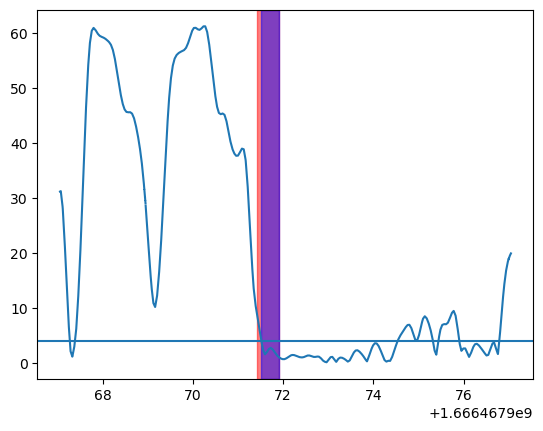

In [29]:
plt.plot(position_info_upsample.iloc[20000:30000].head_speed)
for i in [1]:
    plt.axvspan(extended_start_end[i][0],extended_start_end[i][1],color = 'red',alpha = 0.5)
    plt.axvspan(extended_start_end_lowSpeed[i][0],
                extended_start_end_lowSpeed[i][1],color = 'b',alpha = 0.5)
    plt.axhline(4)

In [54]:
ripple_times = pd.DataFrame((ExtendedRippleTimes() & {'nwb_file_name': nwb_copy_file_name,
                                                      'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [10]:
from spyglass.shijiegu.Analysis_SGU import ExtendedTrialChoiceReplay

In [18]:
log_df = pd.DataFrame((ExtendedTrialChoiceReplay() & {'nwb_file_name': nwb_copy_file_name,
                               'epoch_name': epoch_name}).fetch1('choice_reward_replay'))

In [16]:
mua_thresh = (MUA & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':epoch_name}).fetch1('mean')

## find tetrodes with signal
groups_with_cell=(SpikeSortingRecordingSelection & {
        'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])
channel_IDs = list(neural_df.keys())
    
spikeColInd = {}
for g in groups_with_cell:
    spikeColInd_ = np.argwhere(np.isin(channel_IDs,(Electrode() &  {'nwb_file_name' : nwb_copy_file_name,
                                                     'electrode_group_name':str(g)}).fetch('electrode_id'))).ravel()
    spikeColInd[g] = spikeColInd_

# Pre-make result directory:
decoding_path=(DecodeResultsLinear() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,'extended_SWR',epoch_name)
isExist = os.path.exists(exampledir)
if not isExist:
    os.makedirs(exampledir)
savefolder = exampledir
print(savefolder)



/cumulus/shijie/recording_pilot/eliot/decoding/eliot20221021.nwb/extended_SWR/08_Seq2Session4


In [30]:
linear_map,node_location=get_linearization_map()

[09:42:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
28-Jun-24 09:42:42 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [21]:
epoch_name

NameError: name 'epoch_name' is not defined

In [ ]:
ripple_times = pd.DataFrame((ExtendedRippleTimes() & {'nwb_file_name': nwb_copy_file_name,
                                                      'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [46]:
#ripple_times

In [55]:
r_ind = 6

In [56]:
(t0,t1) = (ripple_times.loc[r_ind,'start_time'],ripple_times.loc[r_ind,'end_time'])
print(t0,t1)

1666564174.5003495 1666564174.5933495


In [64]:
(t0,t1) = (ripple_times.loc[r_ind,'start_time'],ripple_times.loc[r_ind,'end_time'])
linear_position_subset = linear_position_df.isel(time=np.logical_and(linear_position_df.time >= t0,
                                                                                        linear_position_df.time <= t1))
linear_position = np.array(np.mean(linear_position_subset.linear_position))
linear_segment = np.array(linear_position_subset.track_segment_id)[0]
ripple_times.loc[r_ind,'animal_location'] = linear_segment
for k in node_location.keys():
    if np.abs(node_location[k] - linear_position) < 5:
        print(k)
        #ripple_times.loc[r_ind,'animal_location'] = k

In [61]:
node_location

{'home': 0.0,
 'well1': 252.64353221468843,
 'well2': 418.292279561657,
 'well3': 583.1876381171415,
 'well4': 743.0321590705632}

In [63]:
linear_position

array(86.25621407)

In [66]:
MUA()

*nwb_file_name *interval_list mua_trace      mean           sd            
+------------+ +------------+ +------------+ +------------+ +------------+
eliot20221021_ 02_Seq2Session /cumulus/shiji 836.5101206934 1363.924293908
eliot20221021_ 04_Seq2Session /cumulus/shiji 935.3090077968 1767.671744825
eliot20221021_ 06_Seq2Session /cumulus/shiji 976.0121460909 2398.863448428
eliot20221021_ 08_Seq2Session /cumulus/shiji 1062.307521828 2862.902129465
eliot20221022_ 02_Seq2Session /cumulus/shiji 1196.384267059 2042.015461024
eliot20221022_ 04_Seq2Session /cumulus/shiji 1241.074855269 1880.584786315
eliot20221022_ 06_Seq2Session /cumulus/shiji 1125.524807040 3430.659174307
eliot20221022_ 08_Seq2Session /cumulus/shiji 1125.215540387 2806.762422260
eliot20221022_ 10_Seq2Session /cumulus/shiji 1192.853125029 1535.268227374
eliot20221023_ 02_Seq2Session /cumulus/shiji 1724.234911347 2105.818688100
eliot20221023_ 04_Seq2Session /cumulus/shiji 1658.824337175 2164.915091720
eliot20221023_ 06_Seq2Session /cumulus/shiji 1534.242481946 2113.339200319
   ...
 (Total: 22)

### End testing

In [11]:
(epoch_name,log_df,ripple_times,decode,
     head_speed,head_orientation,linear_position_df,
     lfp_df,theta_df,ripple_df,neural_df,mua_df) = replay_parser_master(nwb_file_name,epoch_num,
                                                                       extended = True)

DataJointError: fetch1 should only return one tuple. 0 tuples found

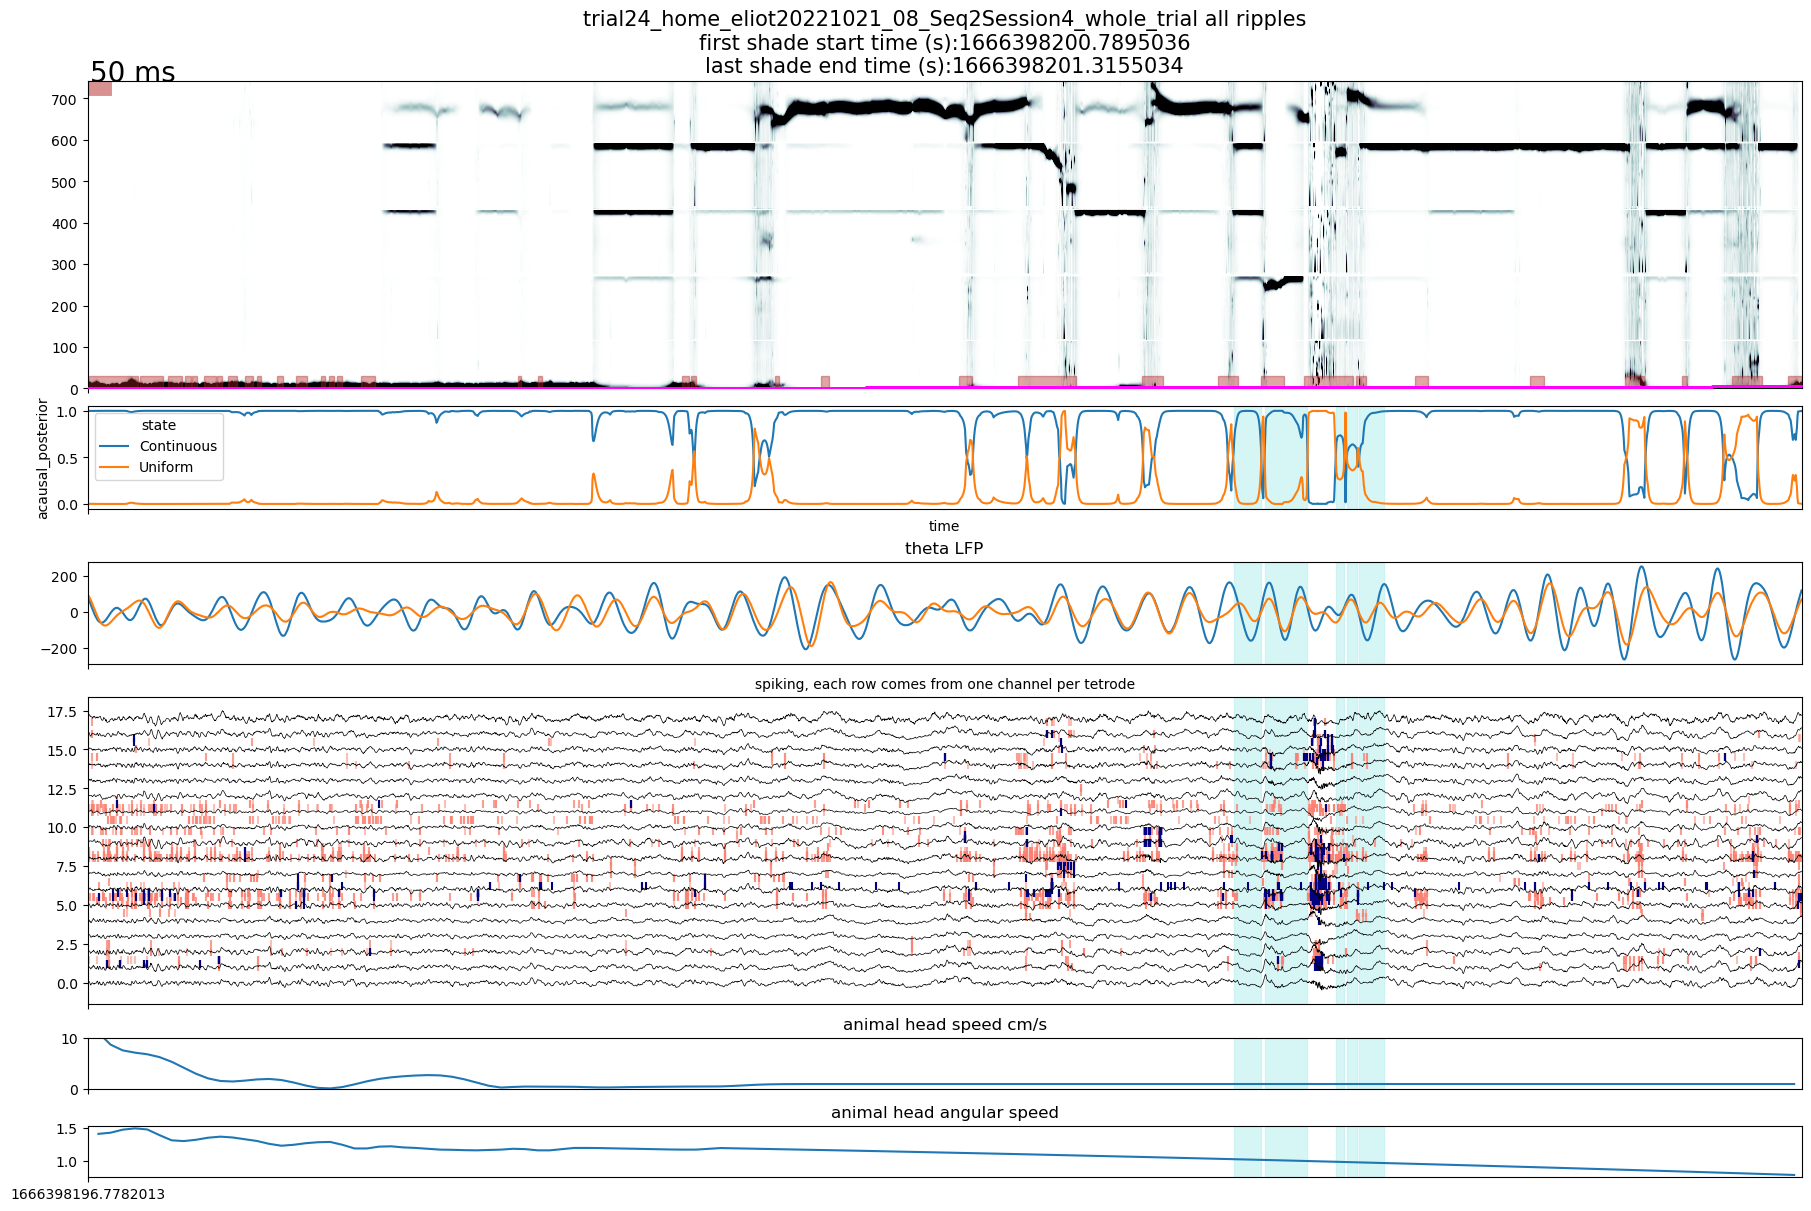

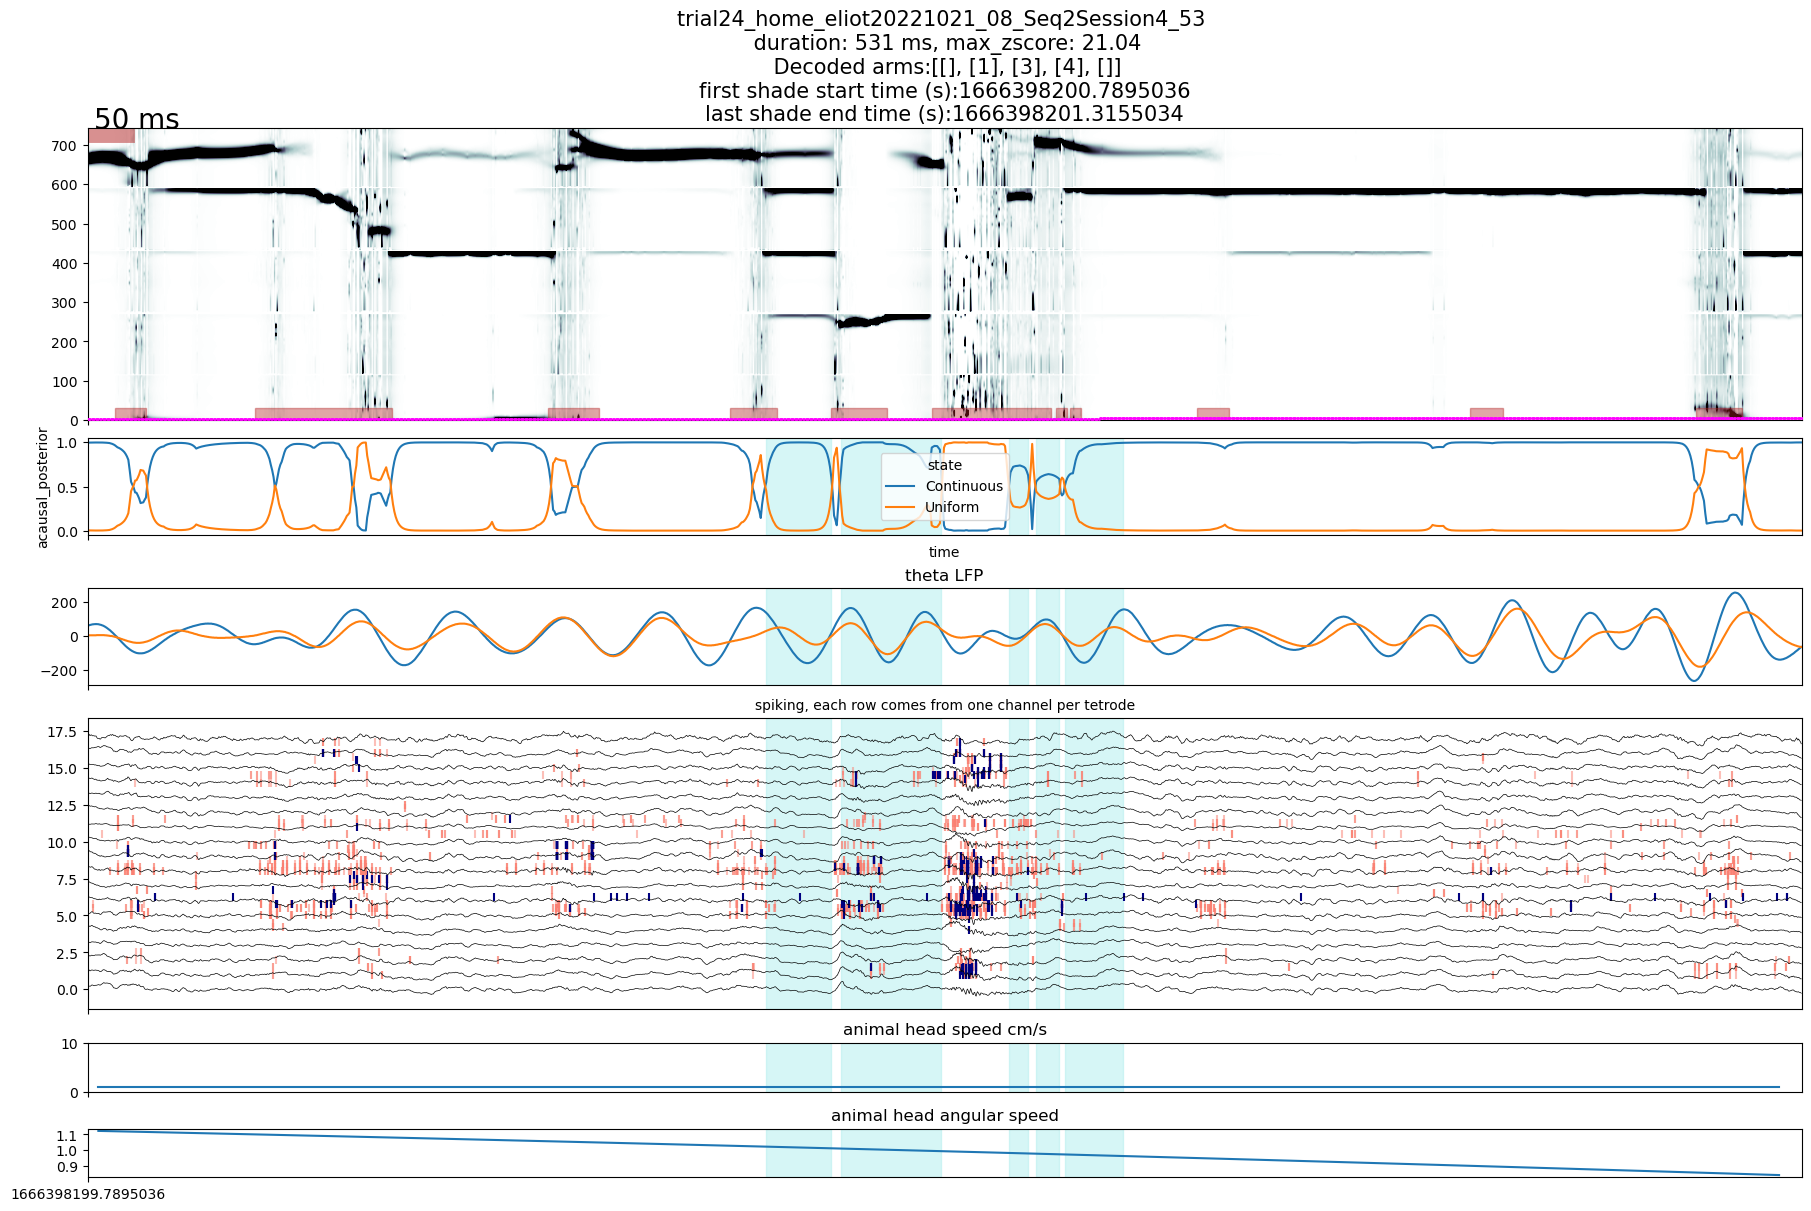

In [27]:
for t in [24]:#log_df.index[:-2]:
    # Home
    ripples = log_df.loc[t].ripple_H
    ripple_table_inds = log_df.loc[t].ripple_ID_H

    if not np.isnan(log_df.loc[t].timestamp_H):
        plottimes = [log_df.loc[t].timestamp_H,log_df.loc[t].timestamp_H + 6]
        savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name + '_whole_trial'
        plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                        linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                        neural_df,mua_df,head_speed,head_orientation,
                        savename,savefolder,wholeTrial = 1,plottimes=plottimes,mua_thresh = mua_thresh)
            
    savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name
    plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                    linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                    neural_df,mua_df,head_speed,head_orientation,
                    savename,savefolder,wholeTrial = 0,mua_thresh = mua_thresh)

In [94]:
#%debug

In [98]:
#log_df

### 2. Visual Inspection

In [67]:
mua_thresh = (MUA & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':epoch_name}).fetch1('mean')

## find tetrodes with signal
groups_with_cell=(SpikeSortingRecordingSelection & {
        'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])
channel_IDs = list(neural_df.keys())
    
spikeColInd = {}
for g in groups_with_cell:
    spikeColInd_ = np.argwhere(np.isin(channel_IDs,(Electrode() &  {'nwb_file_name' : nwb_copy_file_name,
                                                     'electrode_group_name':str(g)}).fetch('electrode_id'))).ravel()
    spikeColInd[g] = spikeColInd_

# Pre-make result directory:
decoding_path=(DecodeResultsLinear() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,'extended_SWR',epoch_name)
isExist = os.path.exists(exampledir)
if not isExist:
    os.makedirs(exampledir)
savefolder = exampledir
print(savefolder)



/cumulus/shijie/recording_pilot/eliot/decoding/eliot20221021.nwb/extended_SWR/02_Seq2Session1


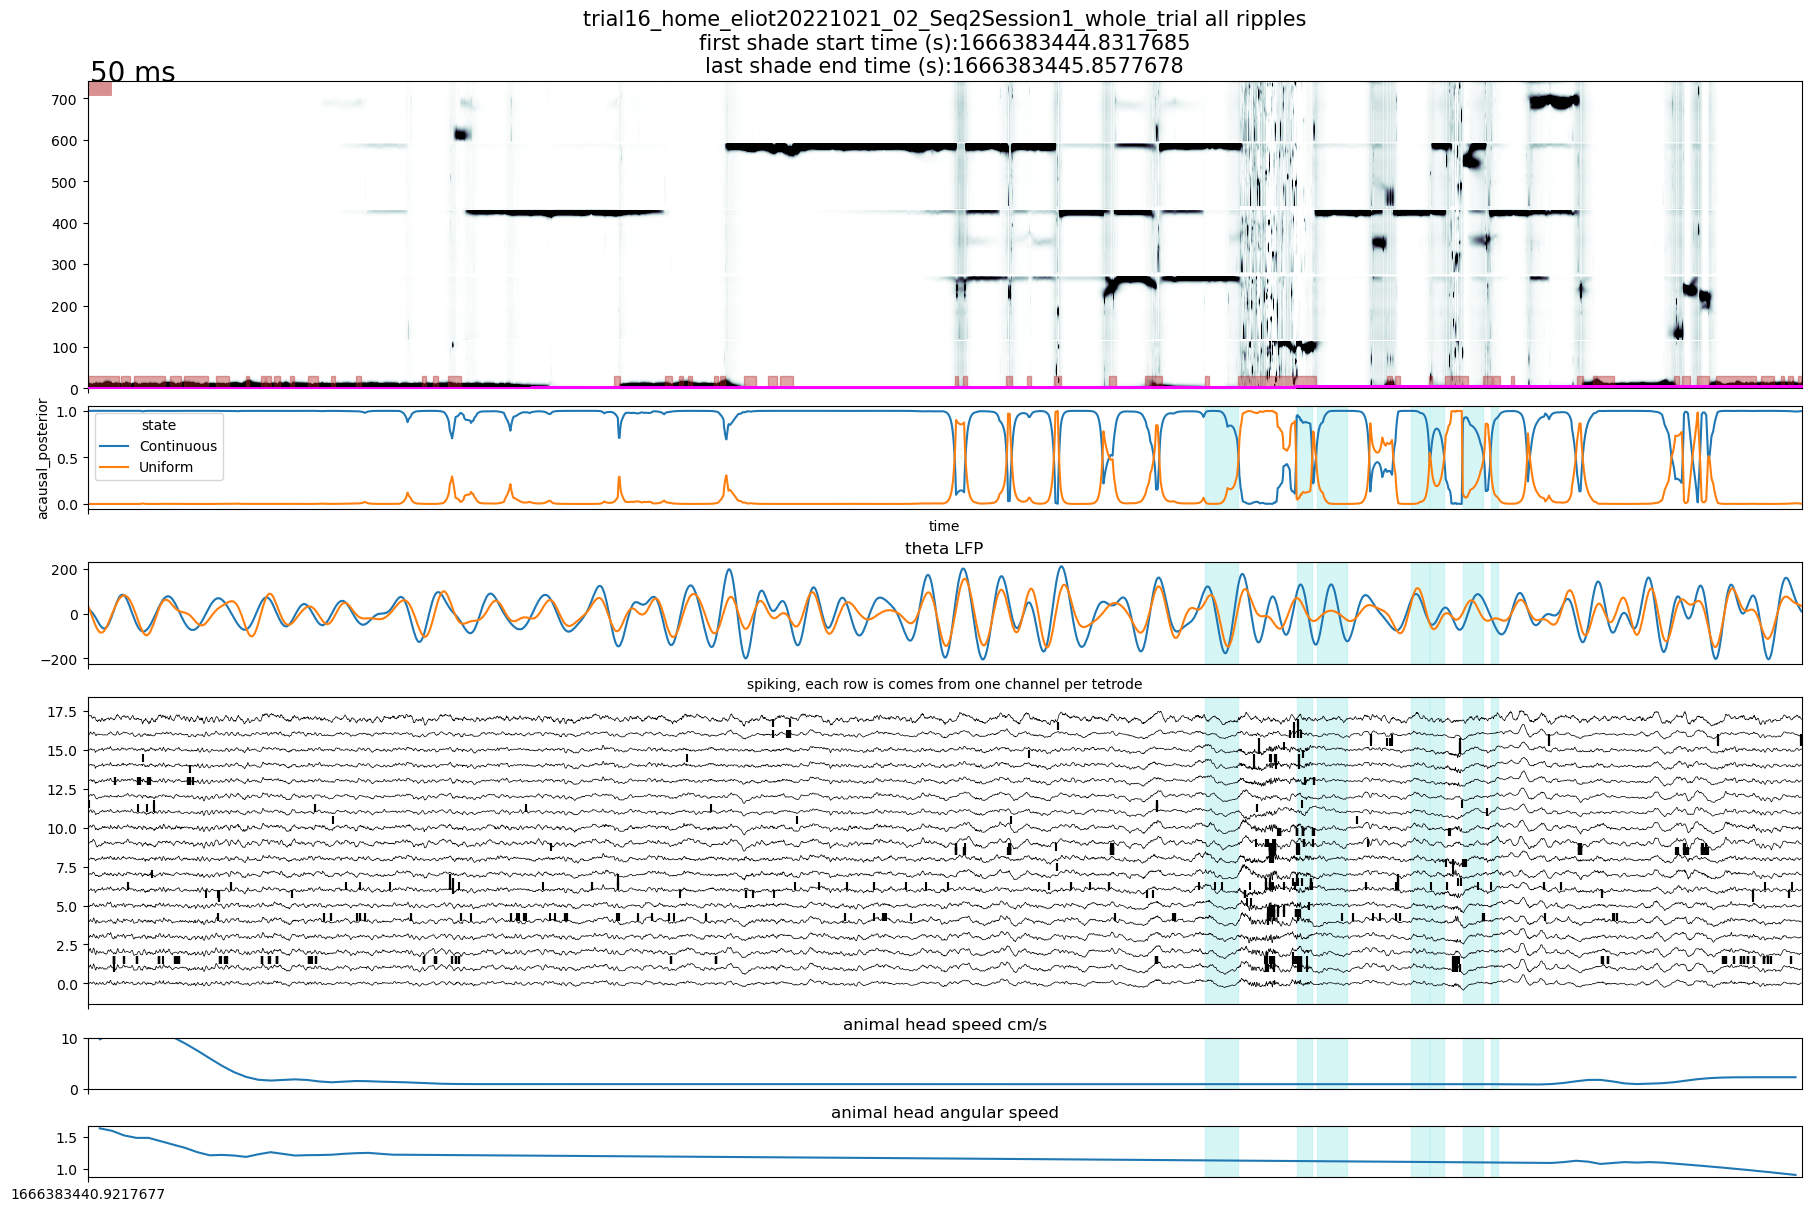

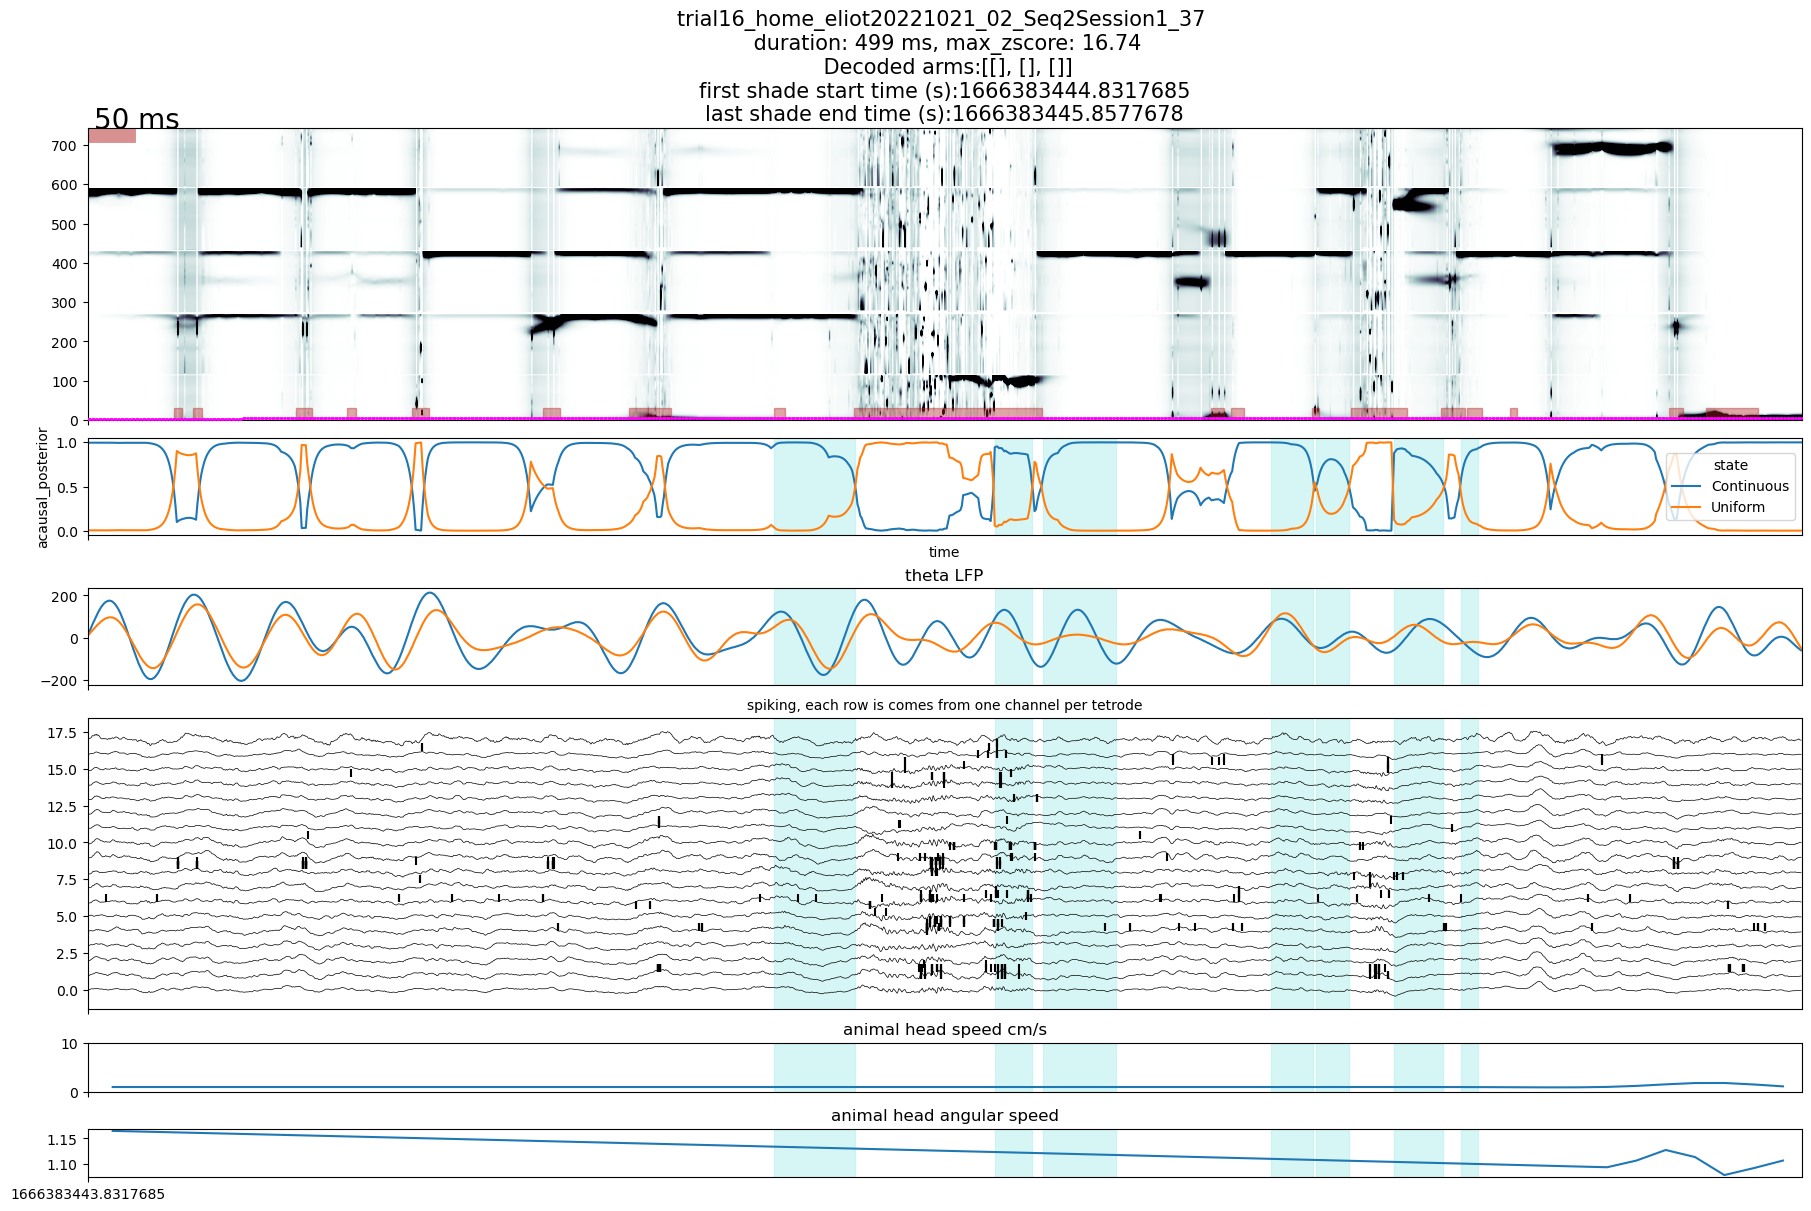

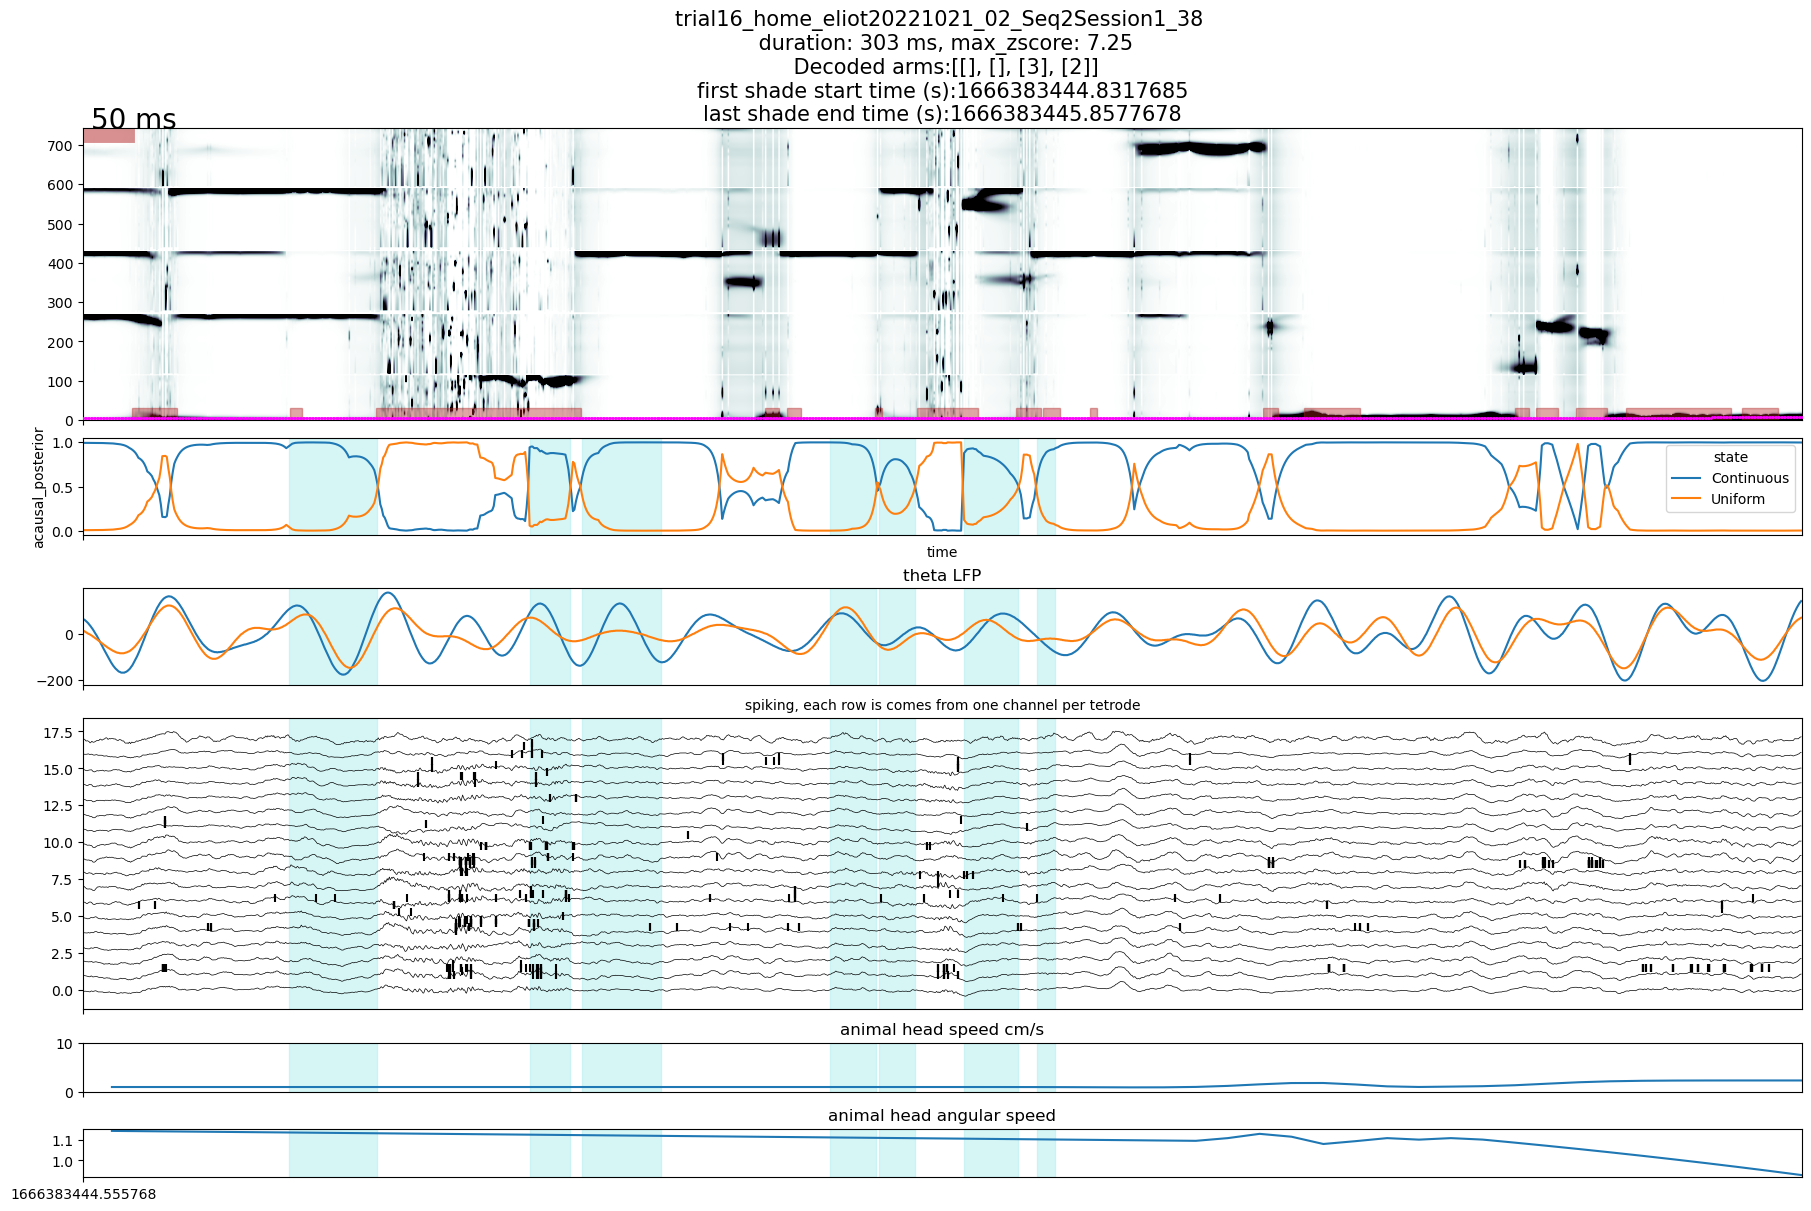

In [68]:
for t in [16]:#log_df.index[:-2]:
    # Home
    ripples = log_df.loc[t].ripple_H
    ripple_table_inds = log_df.loc[t].ripple_ID_H

    if not np.isnan(log_df.loc[t].timestamp_H):
        plottimes = [log_df.loc[t].timestamp_H,log_df.loc[t].timestamp_H + 6]
        savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name + '_whole_trial'
        plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                        linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                        neural_df,mua_df,head_speed,head_orientation,
                        savename,savefolder,wholeTrial = 1,plottimes=plottimes,mua_thresh = mua_thresh)
            
    savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name
    plot_ripples_replays(ripple_times,ripples,ripple_table_inds,
                    linear_position_df,decode,spikeColInd,lfp_df,theta_df,
                    neural_df,mua_df,head_speed,head_orientation,
                    savename,savefolder,wholeTrial = 0,mua_thresh = mua_thresh)

### Begin testing

In [72]:
epoch_name

'06_Seq2Session3'

In [97]:
(ExtendedRippleTimes() & {'nwb_file_name': nwb_copy_file_name})

*nwb_file_name *interval_list ripple_tim
+------------+ +------------+ +--------+
eliot20221023_ 02_Seq2Session =BLOB=    
eliot20221023_ 04_Seq2Session =BLOB=    
eliot20221023_ 06_Seq2Session =BLOB=    
eliot20221023_ 08_Seq2Session =BLOB=    
 (Total: 4)

In [79]:
epoch_num = 8
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
epoch_name=(TrialChoice & key).fetch1('epoch_name')

ripple_times = pd.DataFrame((ExtendedRippleTimes() & {'nwb_file_name': nwb_copy_file_name,
                                                      'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [80]:
from spyglass.shijiegu.ripple_add_replay import add_location_replay
ripple_times = add_location_replay(ripple_times,
                                       linear_position_df,node_location,linear_map,
                                       log_df,
                                       mua_xr,mua_threshold,
                                       decode)

TypeError: add_location_replay() got an unexpected keyword argument 'encoding_set'

In [106]:
epoch_name = (EpochPos() & {'nwb_file_name': nwb_copy_file_name ,'epoch':epoch_num}).fetch1('epoch_name')
key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': epoch_name}
key['ripple_times'] = ripple_times.to_dict()
ExtendedRippleTimes().insert1(key,replace = True)

In [101]:
rippleID = 4

In [110]:
ripple_times

start_time      end_time animal_location  trial_number  \
1    1.666560e+09  1.666560e+09           well3             1   
2    1.666560e+09  1.666560e+09           well3             1   
3    1.666560e+09  1.666560e+09            home             2   
4    1.666560e+09  1.666560e+09            home             2   
5    1.666560e+09  1.666560e+09            home             2   
..            ...           ...             ...           ...   
125  1.666562e+09  1.666562e+09           well4            76   
126  1.666562e+09  1.666562e+09            home            77   
127  1.666562e+09  1.666562e+09            home            78   
128  1.666562e+09  1.666562e+09            home            79   
129  1.666562e+09  1.666562e+09            home            80   

                                            cont_intvl  \
1    [[1666560266.732968, 1666560266.886968], [1666...   
2    [[1666560275.8669634, 1666560276.0129633], [16...   
3    [[1666560284.938959, 1666560285.000959], [1666...   
4    [[1666560287.4289577, 1666560287.5029576], [16...   
5    [[1666560289.1729567, 1666560289.3069568], [16...   
..                                                 ...   
125  [[1666561848.476186, 1666561848.606186], [1666...   
126  [[1666561857.5641816, 1666561857.6681814], [16...   
127  [[1666561877.3641715, 1666561877.5581715], [16...   
128           [[1666561900.6861603, 1666561900.97816]]   
129  [[1666561926.7401474, 1666561926.908147], [166...   

                                            frag_intvl  \
1                                                   []   
2           [[1666560276.0149634, 1666560276.1929631]]   
3    [[1666560285.0789587, 1666560285.132959], [166...   
4    [[1666560287.6089575, 1666560287.6369576], [16...   
5           [[1666560289.3089566, 1666560289.3789566]]   
..                                                 ...   
125           [[1666561848.608186, 1666561848.652186]]   
126                                                 []   
127  [[1666561877.5601716, 1666561877.6961715], [16...   
128                                                 []   
129         [[1666561926.9101472, 1666561926.9681473]]   

               cont_intvl_replay  duration  mean_zscore  median_zscore  \
1             [[3, 4], [3], [3]]     0.429     1.280685       1.059020   
2                   [[2, 4], []]     0.431     0.721273       0.543060   
3                 [[4], [4], []]     0.345     0.977697       0.269607   
4    [[], [4], [2], [], [], [3]]     0.629     2.207745       0.402846   
5                     [[4], [4]]     0.347     0.790076      -0.175696   
..                           ...       ...          ...            ...   
125                [[4], [0, 4]]     0.361     0.811481       0.310203   
126                    [[], [1]]     0.354     0.313821      -0.164748   
127               [[0], [0], []]     0.556     0.899156       0.765022   
128                        [[0]]     0.293     0.437274       0.404524   
129                   [[0], [3]]     0.370     1.769813       0.178070   

     max_zscore  min_zscore  max_speed  min_speed  median_speed  mean_speed  
1      3.898897   -0.111431   3.999812   1.245592      2.932211    2.762619  
2      3.312886   -1.179202   0.589091   0.106431      0.459166    0.420829  
3      9.004062   -0.628644   0.695575   0.135841      0.435968    0.413818  
4     23.153991   -1.062287   0.068896   0.068894      0.068896    0.068896  
5      8.451996   -1.205072   0.068896   0.065811      0.068893    0.068613  
..          ...         ...        ...        ...           ...         ...  
125    6.840270   -0.938518   1.140720   0.139851      0.653851    0.680296  
126    3.458666   -1.160591   0.064280   0.064279      0.064279    0.064279  
127    5.251624   -0.999452   0.331891   0.331890      0.331891    0.331891  
128    3.245474   -0.863070   1.203942   0.056416      0.152417    0.268073  
129   15.668236   -1.309315   0.471327   0.138397      0.277501    0.283221  

[129 r

In [103]:
ripple_times.loc[rippleID].cont_intvl

array([[1.66656029e+09, 1.66656029e+09],
       [1.66656029e+09, 1.66656029e+09],
       [1.66656029e+09, 1.66656029e+09],
       [1.66656029e+09, 1.66656029e+09],
       [1.66656029e+09, 1.66656029e+09],
       [1.66656029e+09, 1.66656029e+09]])

In [104]:
ripple_times.loc[rippleID].cont_intvl_replay

[[], [4], [2], [], [], [3]]

In [105]:
ripple_times.loc[rippleID].cont_intvl[5][0]-ripple_times.loc[rippleID].cont_intvl[2][1]

0.20399999618530273

In [11]:
#ripple_times

In [71]:
(t0,t1) = ripple_times.loc[rippleID].cont_intvl[2]

In [18]:
from spyglass.shijiegu.load import load_decode
decode=load_decode(nwb_copy_file_name,epoch_name)

In [19]:
decode

<xarray.Dataset>
Dimensions:            (time: 1111304, state: 2, position: 301)
Coordinates:
  * time               (time) float64 1.666e+09 1.666e+09 ... 1.666e+09
  * position           (position) float64 0.9938 2.981 4.969 ... 740.1 742.0
  * state              (state) object 'Continuous' 'Uniform'
Data variables:
    likelihood         (time, state, position) float32 ...
    causal_posterior   (time, state, position) float32 ...
    acausal_posterior  (time, state, position) float32 ...
Attributes:
    data_log_likelihood:  -530908.9

In [73]:
mask_time = ((decode.time >= t0) & (decode.time < t1))
position_posterior=decode.isel(time=mask_time).acausal_posterior.sum('state')

In [74]:
from spyglass.shijiegu.ripple_add_replay import position_posterior2arm_posterior
linear_map,node_location=get_linearization_map()
posterior_by_arm = position_posterior2arm_posterior(position_posterior,linear_map)

[20:25:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
23-Jun-24 20:25:05 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


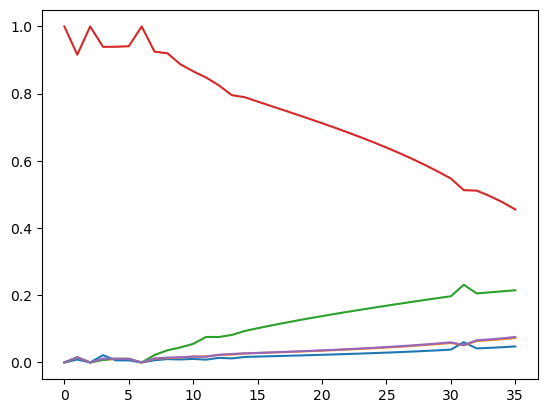

In [79]:
plt.plot(posterior_by_arm.T)

In [80]:
mua_path=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':epoch_name}).fetch1('mua_trace')
mua_xr = xr.open_dataset(mua_path)
mua_threshold=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':epoch_name}).fetch1('mean')


In [81]:
from spyglass.shijiegu.helpers import interpolate_to_new_time
mua_downsample = (interpolate_to_new_time(mua_xr.to_dataframe(), decode.time)).to_xarray()

mua_portion = mua_downsample.isel(time=mask_time).mua
valid_ind = np.array(mua_portion >= mua_threshold)

# only mua > threshold time
posterior_by_arm = posterior_by_arm[:, valid_ind]

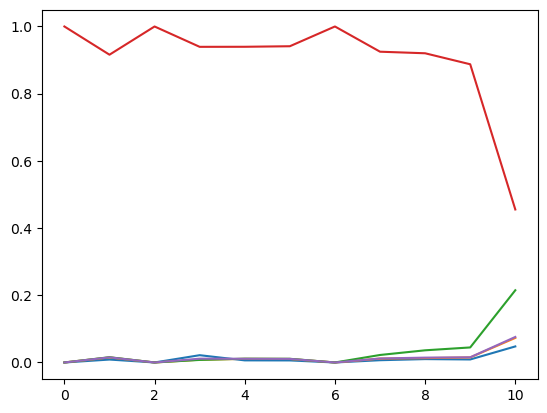

In [83]:
plt.plot(posterior_by_arm.T)

In [50]:
position_posterior_arm_ind = np.argmax(posterior_by_arm, axis = 0)

In [51]:
from spyglass.shijiegu.ripple_add_replay import remove_weak_decode
position_posterior_arm_ind,posterior_by_arm = remove_weak_decode(
    position_posterior_arm_ind,posterior_by_arm)

In [64]:
from spyglass.shijiegu.ripple_add_replay import remove_short_decode
position_posterior_arm_ind,posterior_by_arm = remove_short_decode(
    position_posterior_arm_ind,posterior_by_arm)

In [65]:
position_posterior_arm_ind

array([], dtype=int64)

In [61]:
posterior_by_arm.shape

(5, 3)

In [56]:
valid_ind = np.arange(len(position_posterior_arm_ind))>=0

### End testing

## Ends here

In [ ]:
"""
IMPORTANT!!!! RUN THIS FUNCTION EVERY TIME AFTER A NEW SESSION
USE OF GLOBAL VAR
"""

## find tetrodes with signal
groups_with_cell=(SpikeSortingRecordingSelection & {
    'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])
channel_IDs = list(neural_df.keys())

spikeColInd = {}
for g in groups_with_cell:
    spikeColInd_ = np.argwhere(np.isin(channel_IDs,(Electrode() &  {'nwb_file_name' : nwb_copy_file_name,
                                                 'electrode_group_name':str(g)}).fetch('electrode_id'))).ravel()
    spikeColInd[g] = spikeColInd_

In [ ]:
spikeColInd

In [ ]:
(epoch_name,log_df,decode,head_speed,head_orientation,linear_position_df,
        lfp_df,theta_df,ripple_df,neural_df,mua_df) = load_epoch_data(nwb_copy_file_name,epoch_num)
ripple_times = pd.DataFrame((RippleTimes() & {'nwb_file_name': nwb_copy_file_name,
                                              'interval_list_name': epoch_name}).fetch1('ripple_times'))

In [ ]:
"""
IMPORTANT!!!! RUN THIS FUNCTION EVERY TIME AFTER A NEW SESSION
USE OF GLOBAL VAR
"""

def plot_ripples(ripples,ripple_table_inds,save_name,wholeTrial = 1):
    
    ripples = [r for r in ripples if len(r)>0]
    for ripple_ind in range(len(ripples)):
        t0t1 = np.vstack(ripples) #all possible shadings, just np.vstack(ripples), remove empty segments
        ripple_table_ind = ripple_table_inds[ripple_ind]
        
        if wholeTrial:
            plottimes = [t0t1.ravel()[0]-1,t0t1.ravel()[-1]+1]
            title = f"{save_name} all ripples"
            savename = save_name
        else:
            savename = save_name + str(ripple_table_ind)
            current_t0t1 = ripples[ripple_ind]
            plottimes = [current_t0t1.ravel()[0]-1,current_t0t1.ravel()[-1]+1]
    
            duration = int(ripple_times.loc[ripple_table_ind].duration * 1000)
            max_zscore = round(ripple_times.loc[ripple_table_ind].max_zscore,2)
            title = f"{savename} \n duration: {duration} ms, max_zscore: {max_zscore}"
            title += '\n Decoded arms:' + str(ripple_times.loc[ripple_table_ind].cont_intvl_replay)
    
        plot_decode_spiking(plottimes,t0t1,linear_position_df,decode,lfp_df,theta_df,
              neural_df,mua_df,ripple_df,head_speed,head_orientation,
              ripple_consensus_trace=None,
              title=title,savefolder=savefolder,savename=savename,
              simple=True,tetrode2ind = spikeColInd)
        if wholeTrial:
            break
    

In [ ]:
# Pre-make result directory:
decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,'SWR',epoch_name)
isExist = os.path.exists(exampledir)
if not isExist:
    os.makedirs(exampledir)
savefolder = exampledir
print(savefolder)

In [ ]:
for t in log_df.index[:-2]:

    # Home
    ripples = log_df.loc[t].ripple_H
    ripple_table_inds = log_df.loc[t].ripple_ID_H
    savename = 'trial' + str(t) + '_home_' + nwb_copy_file_name[:-5] + '_' + epoch_name
    plot_ripples(ripples,ripple_table_inds,savename,wholeTrial = 0)
    plot_ripples(ripples,ripple_table_inds,savename,wholeTrial = 1)
    
    # Outer Well
    
    ripples = log_df.loc[t].ripple_O
    ripple_table_inds = log_df.loc[t].ripple_ID_O
    savename = 'trial' + str(t) + '_well_' + nwb_copy_file_name[:-5] + '_' + epoch_name
    plot_ripples(ripples,ripple_table_inds,savename,wholeTrial = 0)
    plot_ripples(ripples,ripple_table_inds,savename,wholeTrial = 1)


In [ ]:
#plt.plot(theta_t,theta_d)

### Plotting

In [ ]:
%%capture stored_output
add_replay(2)
add_replay(4)
add_replay(6)
add_replay(8)

### for whole day

In [ ]:
all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
all_epochs

In [ ]:
%%capture stored_output
with multiprocessing.Pool(3) as p:
    p.map(add_replay,all_epochs)

In [ ]:
stored_output.show()

In [ ]:
print('here')

In [ ]:
add_replay(8)

In [ ]:
%%capture stored_output
add_replay(2)
add_replay(4)
add_replay(6)
add_replay(8)
add_replay(10)

In [ ]:
add_replay(10)
add_replay(12)

In [ ]:
    epoch_num=8
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

In [ ]:
log_df.loc[66,:]

In [ ]:
log_df.loc[66,:].timestamp_H

In [ ]:
linear_position_df = (IntervalLinearizedPosition() &
                      {'nwb_file_name': nwb_copy_file_name,
                       'interval_list_name': epoch_pos_name,
                       'position_info_param_name': 'default_decoding'}
                         ).fetch1_dataframe()

In [ ]:
    t=68
    
    # for each trial, find important times
    t_home=log_df.loc[t,'timestamp_H']
    t_outer=log_df.loc[t,'timestamp_O']
    if t+1<len(log_df):
        t_end=log_df.loc[t+1,'timestamp_H']
    else:
        t_end=log_df.loc[t,'timestamp_H']+10
    
    ''' HOME '''
    # find times close to home well
    time_slice = slice(t_home,t_outer)
    current_location = node_location['home']
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()

In [ ]:
position_subset.index[0]

In [ ]:
position_subset

In [ ]:
    epoch_num=6
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

    # 1.5 Pre-make result directory:
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name)
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)

    # 2. Pre-expand result: Augment choice_reward table to be choice_reward_replay
    log_df_replay=log_df.copy()
    log_df_replay.insert(5,'ripple_H',[[] for i in range(len(log_df))]) #hold ripple times
    log_df_replay.insert(6,'ripple_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(7,'replay_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(8,'ripple_peak_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(9,'replay_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(10,'ripple_peak_O',[[] for i in range(len(log_df))]) #hold decoded replay

    # 3. linear map
    linear_map,node_location=get_linearization_map()

    # 4. load position, decoding, ripple times, mua threshold
    (linear_position_df,decode,ripple_nwb,
     ripple_timestamps,ripple_times,
     recordings,neural_ts,
     mua,mua_time)=load_everything(nwb_copy_file_name,
                    epoch_name,
                    epoch_pos_name)
    


In [ ]:
(IntervalList & {'nwb_file_name': nwb_copy_file_name,'interval_list_name': epoch_pos_name}).fetch1('valid_times')[0]

In [ ]:
    position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name': epoch_pos_name,
                     'position_info_param_name': 'default'}).fetch1_dataframe()

In [ ]:
log_df.loc[60].timestamp_H

In [ ]:
log_df.loc[61].timestamp_H

In [ ]:
log_df.loc[82].timestamp_H

In [ ]:
ripple_timestamps[0]

In [ ]:
position_info.index[0]

In [ ]:
plt.plot(linear_position_df.loc[linear_position_df.index>1650309121,'linear_position'])

In [ ]:
add_replay(10)

In [ ]:
TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name}

In [ ]:
choice_reward_replay=(TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name,
                                            'epoch':2}).fetch1('choice_reward_replay')

In [ ]:
pd.DataFrame(choice_reward_replay)

### one trial

In [ ]:
mua_threshold=np.mean(mua)
mua_threshold

### all trials

In [ ]:
numWorker=30
print('num of worker:',numWorker)
with multiprocessing.Pool(numWorker) as p:
    results=p.map(find_ripple_classify_decode,legal_trials)

In [ ]:
len(results)

In [ ]:
for i in range(len(legal_trials)):
    t=legal_trials[i]
    # add to the choice_reward_replay
    log_df_replay.at[t, 'ripple_H']=results[i][0]
    log_df_replay.at[t, 'ripple_O']=results[i][3]
    
    log_df_replay.at[t, 'replay_H']= results[i][1]
    log_df_replay.at[t, 'replay_O']= results[i][4]
    
    log_df_replay.at[t, 'ripple_peak_H']= results[i][2]
    log_df_replay.at[t, 'ripple_peak_O']= results[i][5]
log_df_replay_subset=log_df_replay.loc[legal_trials,:].copy()

In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
log_df_replay

In [ ]:
# insert into Spyglass
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num,'choice_reward_replay':log_df_replay_subset.to_dict()}
TrialChoiceReplay().make(key,replace=True)

In [ ]:
TrialChoiceReplay()

## investigate short ripples

In [ ]:
short_ripple_H=[]
for i in range(len(legal_trials)):
    t=trial_ind[i]
    ripple_H=log_df_replay.loc[t, 'ripple_H']
    for ri in range(len(ripple_H)):
        if len(ripple_H[ri])==0: #state time is short
            continue
        ripple_=np.reshape(ripple_H[ri],(1,-1))
        if (ripple_[0,-1]-ripple_[0,0])<=0.05:
            short_ripple_H.append((t,ri+1))

In [ ]:
replay_ripple_count=np.zeros((10,5))
replay_ripple=np.zeros((10,5),dtype=np.object)
for i in range(len(trial_ind)):
    t=trial_ind[i]
    replay_all=log_df_replay.loc[t,'replay_O']
    ripple_all=log_df_replay.loc[t,'ripple_peak_O']
    
    for ri in range(len(replay_all)):
        replay=replay_all[ri]
        unique_arms=np.unique(np.setdiff1d(replay,[5]))
        replay_arm_num=len(unique_arms)
    
        ripple_num=len(ripple_all[ri])
        if ripple_num<=10 and replay_arm_num<=5:
            replay_ripple_count[ripple_num-1,replay_arm_num-1]+=1
            if type(replay_ripple[ripple_num-1,replay_arm_num-1])=='list':
                replay_ripple[ripple_num-1,replay_arm_num-1].append(replay)
            else:
                replay_ripple[ripple_num-1,replay_arm_num-1]=replay

In [ ]:
replay_ripple[:,2]

In [ ]:
fig, axes = plt.subplots(nrows=1)
plt.imshow(np.flipud(replay_ripple_count.T))
axes.set_xlabel('ripple peak number')
axes.set_ylabel('distinct arms in replay')
axes.set_yticks([2,3,4])
axes.set_yticklabels(['3','2','1'])